In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Data Preprocessing

In [26]:
df = sns.load_dataset('diamonds')

In [27]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [28]:
print(df.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


In [29]:
print(df.duplicated().sum())

146


In [30]:
df.drop_duplicates(inplace=True)

In [31]:
print(df.duplicated().sum())

0


In [32]:
print(df.head())

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [33]:
print(df.describe())

             carat         depth         table         price             x  \
count  53794.00000  53794.000000  53794.000000  53794.000000  53794.000000   
mean       0.79778     61.748080     57.458109   3933.065082      5.731214   
std        0.47339      1.429909      2.233679   3988.114460      1.120695   
min        0.20000     43.000000     43.000000    326.000000      0.000000   
25%        0.40000     61.000000     56.000000    951.000000      4.710000   
50%        0.70000     61.800000     57.000000   2401.000000      5.700000   
75%        1.04000     62.500000     59.000000   5326.750000      6.540000   
max        5.01000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53794.000000  53794.000000  
mean       5.734653      3.538714  
std        1.141209      0.705037  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.030000  
max      

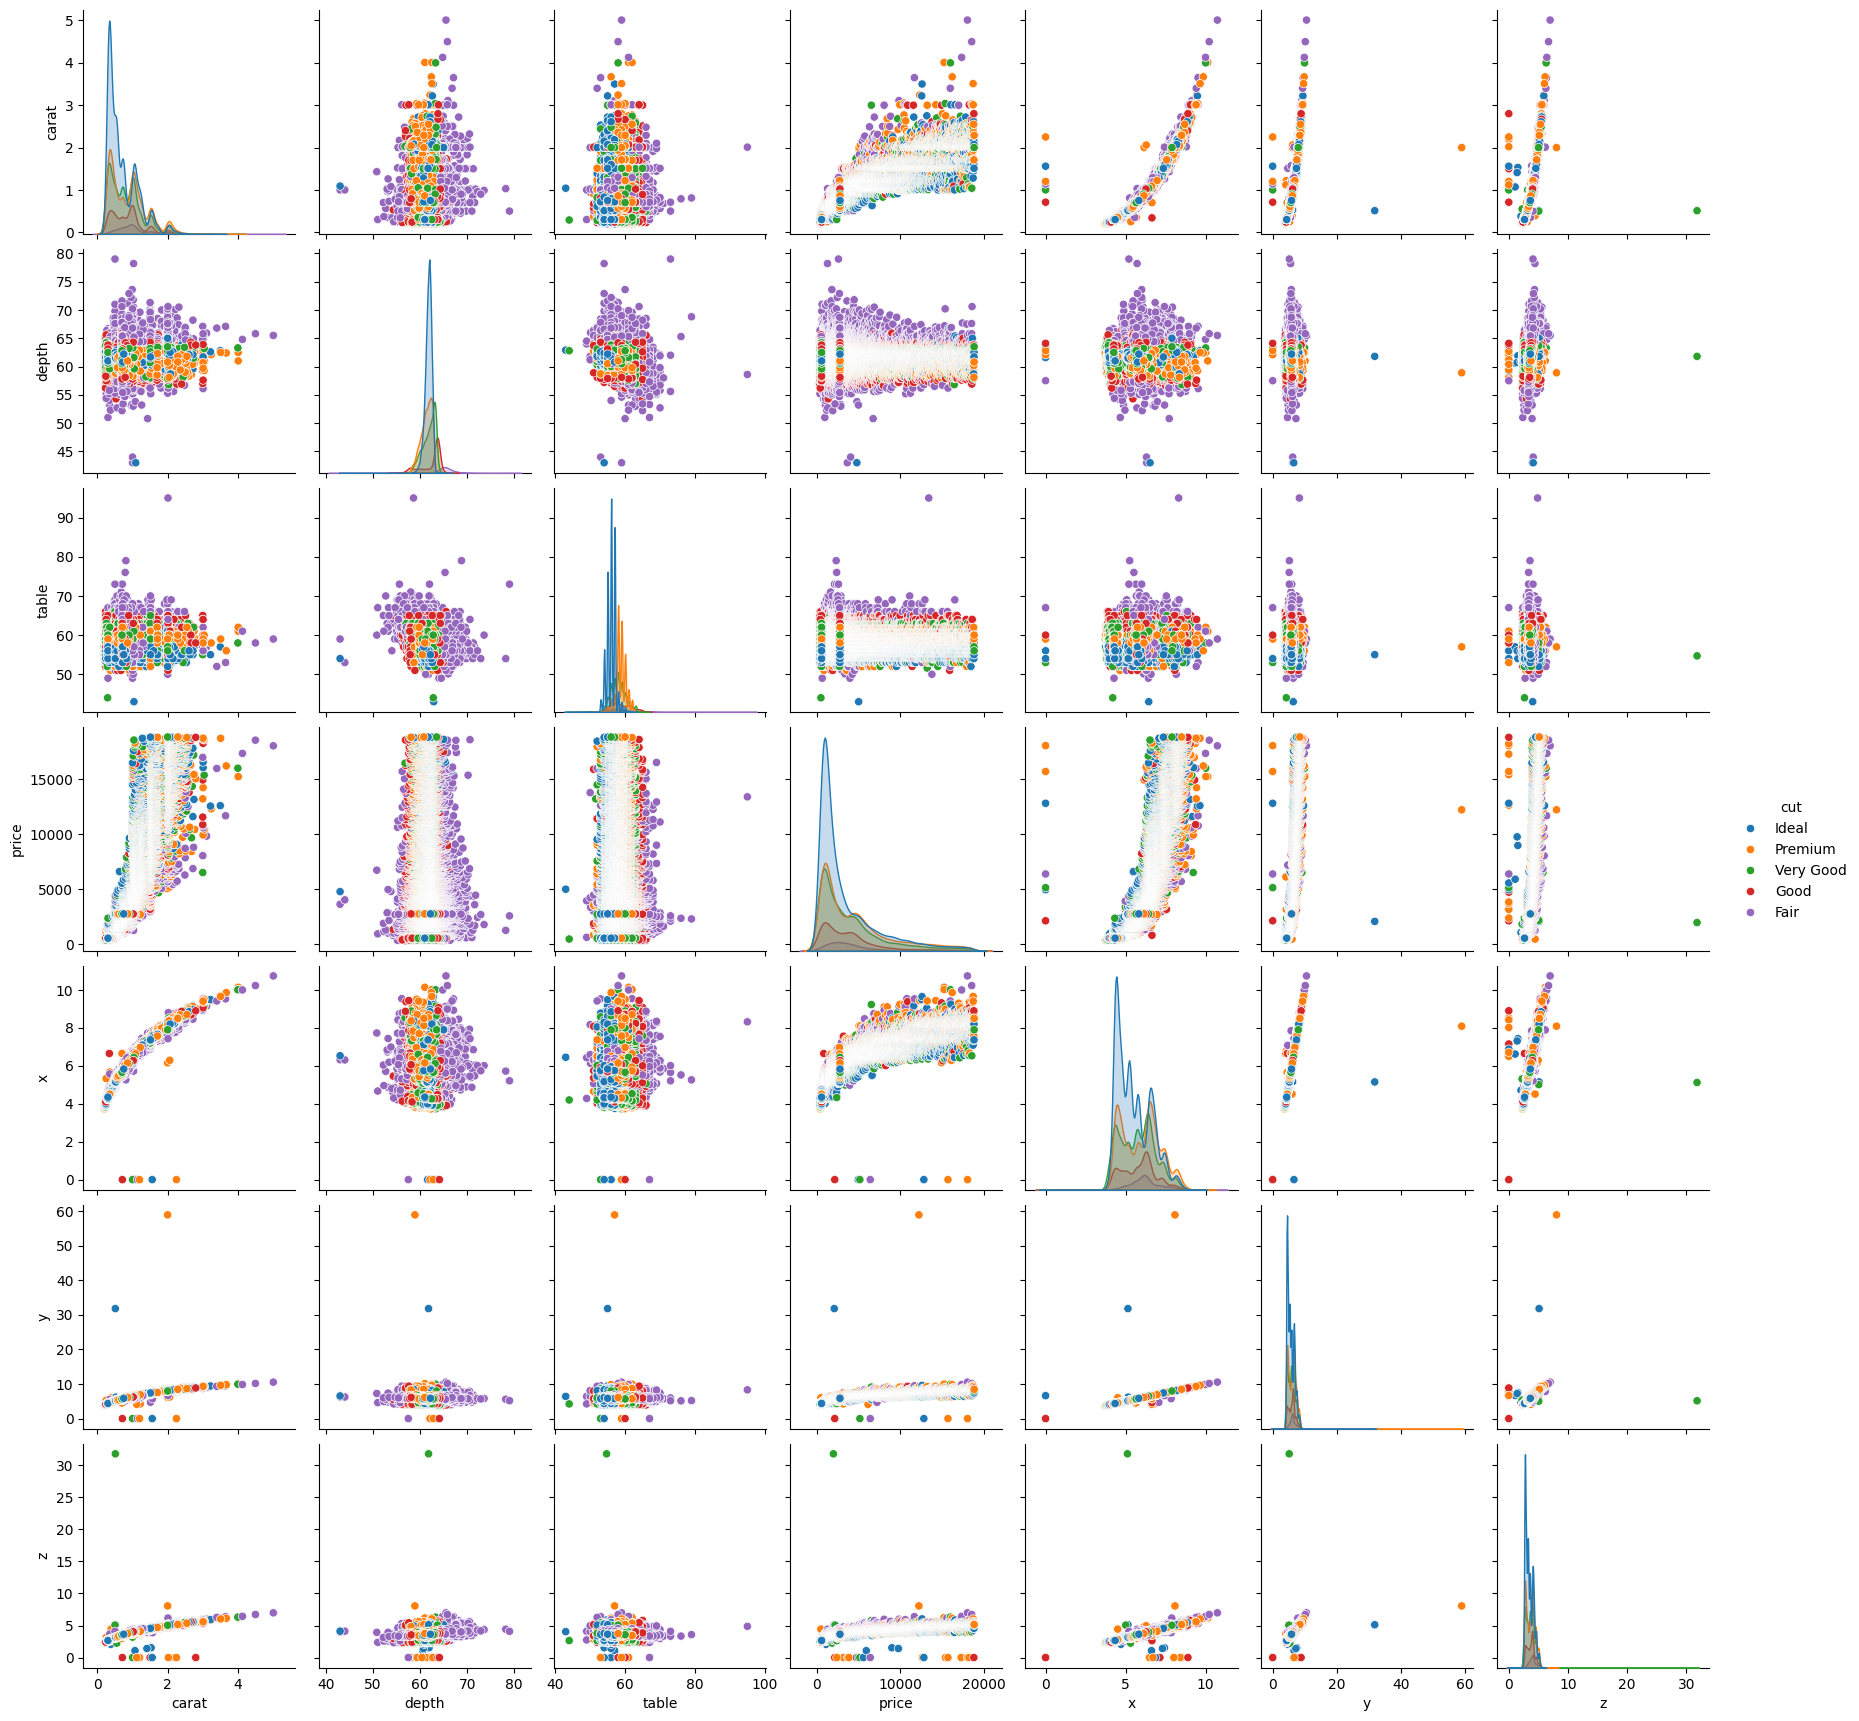

In [34]:
sns.pairplot(df, hue='cut', diag_kind='kde')
plt.show()
# This will create a pairwise scatter plot of the numerical features in the dataset, colored by the 'cut' feature. 
# We can observe the distributions and relationships between different features.

In [35]:
# The 'cut' and 'color' features are categorical. We can convert them to numerical values using one-hot encoding or label encoding.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label encoding for 'cut'
le = LabelEncoder()
df['cut'] = le.fit_transform(df['cut'])

# One-hot encoding for 'color'
ohe = OneHotEncoder()
color_ohe = ohe.fit_transform(df[['color']]).toarray()
color_cols = ohe.get_feature_names_out(['color'])
df = df.join(pd.DataFrame(color_ohe, columns=color_cols, index=df.index))

In [36]:
# scale or normalize the numerical features, so that they have similar ranges and distributions.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [37]:
# Feature Engineering

In [38]:
# The dataset contains dimensions like x, y, and z. We can create a new feature called volume by multiplying these dimensions.
df['volume'] = df['x'] * df['y'] * df['z']

In [39]:
df['length_width_ratio'] = df['x'] / df['y']

In [40]:
df['depth_width_ratio'] = df['depth'] / df['y']

In [41]:
# In some cases, it might be better to treat the target variable ('price') as a categorical variable instead of a continuous one. 
# We can bin the 'price' feature into different price ranges.
bins = [0, 1000, 3000, 6000, 10000, np.inf]
labels = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High']
df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels)

In [42]:
df['carat_cut'] = df['carat'] * df['cut']
df['depth_table'] = df['depth'] * df['table']

In [43]:
# there might be non-linear relationships between the features and the target variable
# We can create polynomial features by combining the existing features.

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df[['carat', 'depth', 'table']])
poly_cols = poly.get_feature_names_out(['carat', 'depth', 'table'])
df_poly = pd.DataFrame(X_poly, columns=poly_cols, index=df.index)
df = pd.concat([df, df_poly], axis=1)

In [46]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [48]:
df = sns.load_dataset('diamonds')
print(df.shape)  #  (53940, 10)
print(df.head())

(53940, 10)
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [49]:
#Remove non numeric columns.
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
print(df.shape)   #  (53940, 7)
print(df.head())

(53940, 7)
   carat  depth  table  price     x     y     z
0   0.23   61.5   55.0    326  3.95  3.98  2.43
1   0.21   59.8   61.0    326  3.89  3.84  2.31
2   0.23   56.9   65.0    327  4.05  4.07  2.31
3   0.29   62.4   58.0    334  4.20  4.23  2.63
4   0.31   63.3   58.0    335  4.34  4.35  2.75


In [50]:
#Let's check columns that contain outliers.
for col in df.columns:
    print(col, check_outlier(df, col))

carat True
depth True
table True
price True
x True
y True
z True


In [52]:
# Let's see how many rows contain outlier 'carat'
low, up = outlier_thresholds(df, "carat")
print(df[((df["carat"] < low) | (df["carat"] > up))].shape)  # (1889, 7)
# As you can see there are so many 'carat' outlier.

(1889, 7)


In [53]:
# see how many rows contain outlier 'depth'
low, up = outlier_thresholds(df, "depth")
print(df[((df["depth"] < low) | (df["depth"] > up))].shape)  # (2545, 7)
# And there are also many 'depth' outlier.


(2545, 7)


In [55]:
from sklearn.neighbors import LocalOutlierFactor
# Now we will create a Local Outlier Factor with n_neighbors = 20
# Generally, we use n_neighbors = 20
# Then, we will transform each point to a score according to the LOF.
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
print(df_scores)
# [-1.58352526 -1.59732899 -1.62278873 ... -1.06721815 -1.00809552  -1.00849038]
# These points are negative and there are 53940 points. The closer to -1, the higher the chance of not being an outlier.

[-1.58352526 -1.59732899 -1.62278873 ... -1.06721815 -1.00809552
 -1.00849038]


In [56]:
#Let's sort df_scores and see first 5 of them.
print(np.sort(df_scores)[0:5]) # array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])

[-8.60430658 -8.20889984 -5.86084355 -4.98415175 -4.81502092]


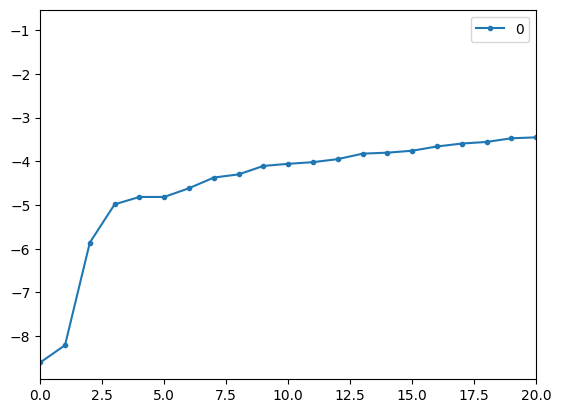

In [57]:
#Now see first 20 sorted  df_scores.
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()  

In [58]:
th = np.sort(df_scores)[3] # 4th point is our threshold.
print(th)   

-4.984151747711709


In [59]:
#Now let's look at the rows that are outliers.
print(df[df_scores < th])

       carat  depth  table  price     x      y      z
41918   1.03   78.2   54.0   1262  5.72   5.59   4.42
48410   0.51   61.8   54.7   1970  5.12   5.15  31.80
49189   0.51   61.8   55.0   2075  5.15  31.80   5.12


In [60]:
#And we drop these above 3 rows from our dataset...
print(df.drop(axis=0, labels=df[df_scores < th].index).shape) #(53937, 7)

(53937, 7)
